# Reference
C.A. van Eysden & A. Melatos, MNRAS. 409 (2010) 1253.

## test case
Vela_1985 July 12. 
data from McCulloch et al. (1987).

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.misc import derivative

## two-component spin-up model

### parameters of model

In [78]:
# Fig. 2. (a)
# dimensionless parameters
K       =   1.0
B       =   2.28e-8
E       =   9.28e-19

# viscous, scaled to total density: rho
rho_n   =   0.1

# viscous, total mass flux, scaled to dlt_Omega
Omega_n0=   0.38
Omega_0 =   0.68

beta    =   B / np.sqrt(E)

effs = {'K':K, 'B':B, 'E':E, 'rho_n':rho_n, 'Omega_n0':Omega_n0, 'Omega_0':Omega_0, 'beta':beta}


# 20/7*0.01*53, 0.97, 0.97, 50/np.sqrt(3.05e5)
K       =   53
B       =   50
E       =   3.05e5

# viscous, scaled to total density: rho
rho_n   =   0.01

# viscous, total mass flux, scaled to dlt_Omega
Omega_n0=   0.97
Omega_0 =   0.97

beta    =   B / np.sqrt(E)

In [79]:
# formula (11), the radius-dependent time-scales omega_pm^{-1}
# a mixture of the classical Ekman time-scale 
# & the superfluid mutual friction coupling time-scale 

def omega_pm(r, pm):
    z2       =   1. - np.square(r)
    z_term   =   np.power(z2, -0.75)

    term1    =   - 0.5 * (beta + z_term)
    term2    =   np.sqrt(np.power(term1, 2) - beta * rho_n * z_term)

    if pm == '+':
        result = term1 + term2
    elif pm == '-':
        result = term1 - term2
    else:
        print("An unexpected error occurred:", pm)
        result = None

    return result

print(omega_pm(0.999999999999999, '+'))

-0.00090789794921875


In [80]:
# formula (15), defined to calc formula (14)

def gA_to_quad(tau, r):
    omg_p   =   omega_pm(r, '+')
    omg_m   =   omega_pm(r, '-')
    z       =   np.sqrt(1 - np.square(r))

    # calc the num. & den.
    numerator   =   np.power(r, 3) * (np.exp(omg_p * tau) - np.exp(omg_m * tau))
    denominator =   np.sqrt(z) * (omg_p - omg_m)

    result  =   7.5 * numerator / denominator
    return result


# 定义被积函数中 tau 的积分函数
def gA(tau):
    return quad(lambda r: gA_to_quad(tau, r), 0, 1)[0]


# formula (16), defined to calc formula (14)
def gB(tau):
    result, error   =   quad(gA, 0, tau)
    result  =   beta * result
    return result



In [81]:
# formula (14)-(16), an integral equation for 
# the spin evolution of the crust

# to solve it numerically, guessing an initial 
# trial function for f(tau) (e.g. exponential),
# substituting it into the right-hand side of (14),
# updating f(tau) via underrelaxation (Press et al. 2002),
# and iterating.

def f_term1_to_quad(tau, tau_prime):
    gA_prime  =   derivative(gA, tau - tau_prime, dx=1e-6)
    gB_prime  =   derivative(gB, tau - tau_prime, dx=1e-6)
    result    =   - rho_n * K * (gA_prime + gB_prime) * np.exp(tau_prime)
    return result


def f_term1(tau):
    result, error = quad(lambda tau_prime: f_term1_to_quad(tau, tau_prime), 0, tau)
    return result


def f_model(tau):
    term2   =   rho_n * K * (gA(tau) * Omega_n0 + gB(tau) * Omega_0) + 1
    result  =   f_term1(tau) + term2
    return result

# print(f_model(0.01))

## OBS data fit parameter -- plot

In [82]:
# pre-glitch, unit: Hz
nu_g0       =   11.2016866562
Omega       =   2.0 * np.pi * nu_g0

# unit: muHz
dlt_nu      =   17.9
dlt_nu_p    =   15.1 
dlt_nu_1    =   2.76
dlt_nu_2    =   0.066
# dlt_nu_3    =   12.8
# dlt_nu_4    =   12.8

# scaled to dlt_nu
dlt_nu_list = np.array([dlt_nu_1, dlt_nu_2]) / dlt_nu

# unit: d
t_1         =   332.0
t_2         =   6.5
# t_3         =   233
# t_4         =   233
t_list      = np.array([t_1, t_2])



In [83]:
# formula (19)
def f_obs(tau):

    # summation of terms of power law 
    sum = 0.0
    for i in range(len(dlt_nu_list)):
        powerlaw = np.exp(- tau / (np.sqrt(E) * 2.0 * np.pi * nu_g0 * t_list[i]))
        sum     += dlt_nu_list[i] * powerlaw

    # f_obs
    obs = dlt_nu_p / dlt_nu + sum

    return obs

In [84]:
numdays = 120

# variable, unit: d
t   =   np.arange(0, numdays, 1)

# Ekman time, scale the time coord.
tau = np.sqrt(E) * Omega * t

#
Y_obs   =   f_obs(tau)




In [85]:
y_gA  = []
for i in range(numdays):
    y_gA.append(gA(tau[i]))

In [86]:
# test gA(tau)

def gA1(tau):
    return 20./7.*tau

def gA2(tau):
    result = - (10./7. * beta - 15./8.) * np.square(tau)
    return result



y_gA1 = gA1(tau)
y_gA2 = gA2(tau)
y_gA  = np.array(y_gA)

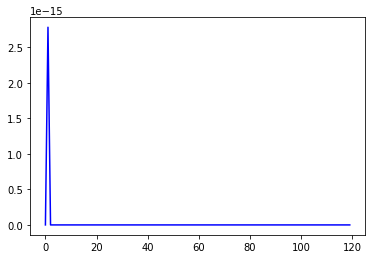

In [87]:
# plt.plot(t, y_gA1    - y_gA, color='red')
plt.plot(t, y_gA, color='blue')

### glitch-model-analytical

In [88]:
# Fig. 2. (a)
# dimensionless parameters
# K       =   1.0
# B       =   2.28e-8
E       =   9.28e-19

# viscous, scaled to total density: rho
a_rho_n_K   =   1. / (np.sqrt(E) * 2 * np.pi * nu_g0) * (1/t_1 + 1/t_2)

# viscous, total mass flux, scaled to dlt_Omega
# Omega_n0=   0.38
c_Omega_0 =   dlt_nu_p / dlt_nu


temp1    =   1. / (np.sqrt(E) * 2 * np.pi * nu_g0) / t_1
temp2    =      1. / (np.sqrt(E) * 2 * np.pi * nu_g0) / t_2

d_beta    =   1.0/4 * (a_rho_n_K - np.power(temp1 - temp2, 2) / a_rho_n_K)

b_Omega_n0       =   1.0/2 * (1 + c_Omega_0 + np.sqrt(1 - 4 * (d_beta/a_rho_n_K)) * abs(dlt_nu_1 - dlt_nu_2) / dlt_nu)

coeffs  =   [a_rho_n_K, b_Omega_n0, c_Omega_0, d_beta]
# coeffs  =   [20./7 * rho_n * K, Omega_n0, Omega_0, beta]

print(effs)
print(coeffs)

{'K': 1.0, 'B': 2.28e-08, 'E': 9.28e-19, 'rho_n': 0.1, 'Omega_n0': 0.38, 'Omega_0': 0.68, 'beta': 23.667961758315894}
[2313502.4096819083, 0.9941490968205111, 0.8435754189944135, 43571.65442373115]


In [89]:
def f_ana(tau):
    result = coeffs[2]
    print(coeffs[0] - 4 * coeffs[3])
    effs1  = np.sqrt(coeffs[0]) * (2 * coeffs[1] - coeffs[2] - 1)
    effs2  = np.sqrt(coeffs[0] - 4 * coeffs[3]) * (coeffs[2] - 1)
    effs3  = np.sqrt(coeffs[0] * (coeffs[0] - 4 * coeffs[3]))

    term1  = (effs1 + effs2) * np.exp(- 0.5 * tau * (effs3 + coeffs[0]))
    term2  = (-effs1 + effs2) * np.exp(- 0.5 * tau * (- effs3 + coeffs[0]))

    result = result - (term1 + term2) / 2.0 / np.sqrt(coeffs[0] - 4 * coeffs[3])
                                      
    return result

# Y_ana = f_ana(tau) 

In [90]:
# formula (14)-(16), an integral equation for 
# the spin evolution of the crust

# to solve it numerically, guessing an initial 
# trial function for f(tau) (e.g. exponential),
# substituting it into the right-hand side of (14),
# updating f(tau) via underrelaxation (Press et al. 2002),
# and iterating.

def f_term1_to_quad(tau, tau_prime):
    gA_prime  =   derivative(gA, tau - tau_prime, dx=1e-6)
    gB_prime  =   derivative(gB, tau - tau_prime, dx=1e-6)
    result    =   - rho_n * K * (gA_prime + gB_prime) * np.exp(tau_prime)
    return result


def f_term1(tau):
    result, error = quad(lambda tau_prime: f_term1_to_quad(tau, tau_prime), 0, tau)
    return result


def f_model(tau):
    term2   =   rho_n * K * (gA(tau) * Omega_n0 + gB(tau) * Omega_0) + 1
    result  =   f_term1(tau) + term2
    return result



In [91]:
Y_ana = []
for i in range(numdays):
    Y_ana.append(f_ana(numdays))

2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919869837
2139215.7919

### Plot block

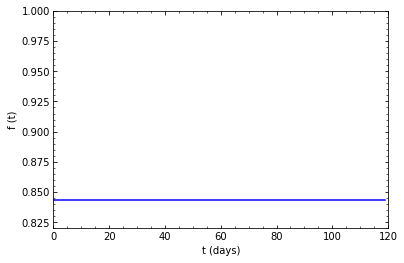

In [92]:
# plot
# plt.plot(t, Y_obs, color='red')
plt.plot(t, Y_ana, color='blue')

#
plt.xlim(0,numdays)
plt.ylim(0.82, 1.)
plt.xlabel('t (days)')
plt.ylabel('f (t)')

# set the minor ticks
plt.minorticks_on()

# set tick params
plt.tick_params(axis="both", which="both", direction="in", 
                top=True, bottom=True, left=True, right=True)



In [2]:
from sympy import symbols, solve, exp

# 定义符号变量和函数
s = symbols('s')
f = exp(s) / (s**3 + s**2 + s**1 + 1)

# 分解函数，得到分子和分母
numerator, denominator = f.as_numer_denom()

# 解分母为零的方程，得到函数的极点
denominator_zero_points = solve(denominator, s)

# 打印结果
print("函数的极点:", denominator_zero_points)


函数的极点: [-1, -I, I]
